# 🧑‍🏫 Lab X — Benchmarking Anthropic Models for Web-to-HTML Reconstruction

**Goals**

1. **Load** a screenshot of a webapp page (PNG/JPG)  
2. **Invoke** multiple Claude models on AWS Bedrock  
3. **Ask** each model to reproduce the HTML that generated the page  
4. **Capture & compare** latency, token usage, reasoning chains, and cost  
5. **Render** each generated HTML in the notebook for quick visual feedback


In [1]:
# 0. Environment Setup

# install AWS SDK, image handling, and table/output helpers
%pip install -q boto3 pillow pandas tabulate rich tqdm

Note: you may need to restart the kernel to use updated packages.


# 1. Imports & Configuration

In [2]:
import os  # Added for environment variable access
from pathlib import Path
import json
import logging
import base64
from dataclasses import dataclass, field
from datetime import datetime, timezone  # timezone explicitly imported
from time import sleep
from typing import Any, Dict, List, Optional, Tuple, Union  # Union added

import boto3
from botocore.config import Config
import pandas as pd
from rich.console import Console
from rich.table import Table
from tabulate import tabulate
from tqdm.auto import tqdm
from IPython.display import (
    HTML,
    display,
    Image as IPImage,
)  # Added IPImage for displaying input image

# Logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(name)s: %(message)s"
)
logger = logging.getLogger("webapp_html_benchmark")
console = Console()

# AWS Bedrock client
AWS_REGION = os.getenv("AWS_REGION", "us-east-1")  # Made more flexible
bedrock_config = Config(
    connect_timeout=10, read_timeout=300, retries={"max_attempts": 3}
)
bedrock_client = boto3.client(
    "bedrock-runtime", region_name=AWS_REGION, config=bedrock_config
)
logger.info(f"Using AWS Region: {AWS_REGION}")

2025-05-07 15:04:06,137 [INFO] botocore.credentials: Found credentials in shared credentials file: ~/.aws/credentials
2025-05-07 15:04:06,279 [INFO] webapp_html_benchmark: Using AWS Region: us-east-1


# 2. Model Catalogue & Cost Reference

In [3]:
@dataclass
class ModelConfig:
    key: str
    display_name: str
    model_id: str
    max_output_tokens: int = (
        8192  # Renamed for clarity, Claude 3 can go higher but this is a common default
    )
    temperature: float = (
        1  # Adjusted default temp, 1.0 can be too creative for reconstruction
    )
    thinking: Dict[str, Any] = field(default_factory=dict)
    price_in_per_1M: float = 0.0
    price_out_per_1M: float = 0.0

    @property
    def rate_in(self) -> float:
        return self.price_in_per_1M / 1e6

    @property
    def rate_out(self) -> float:
        return self.price_out_per_1M / 1e6


# Update with your region‐prefix logic if needed
def _geo_prefix(region: str) -> str:
    if region.startswith("us-"):
        return "us."
    if region.startswith("eu-"):
        return "eu."
    # Defaulting to "ap." for other regions, including "ca-", "sa-", etc.
    # This logic might need refinement for broader applicability.
    return "ap."


PFX = _geo_prefix(AWS_REGION)
logger.info(
    f"Using PFX: '{PFX}' for model IDs based on region '{AWS_REGION}'. This may be specific to your lab environment."
)

# Per‐million‐token pricing
PRICING = {
    "claude3-haiku": (0.25, 1.25),  # Standard Claude 3 Haiku pricing for reference
    "claude3.5-sonnet": (3.0, 15.0),  # Standard Claude 3.5 Sonnet pricing for reference
    "haiku3.5": (0.8, 4.0),
    "sonnet3.5v2": (3.0, 15.0),
    "sonnet3.7": (3.0, 15.0),
}

EVAL_MODELS: List[ModelConfig] = [
    ModelConfig(
        key="haiku3.5",
        display_name="Claude 3.5 Haiku (Lab ID)",
        model_id=f"{PFX}anthropic.claude-3-5-haiku-20241022-v1:0",  # Lab-specific ID
        price_in_per_1M=PRICING["haiku3.5"][0],
        price_out_per_1M=PRICING["haiku3.5"][1],
    ),
    ModelConfig(
        key="sonnet3.5v2",
        display_name="Claude 3.5 Sonnet v2 (Lab ID)",
        model_id=f"{PFX}anthropic.claude-3-5-sonnet-20241022-v2:0",  # Lab-specific ID
        price_in_per_1M=PRICING["sonnet3.5v2"][0],
        price_out_per_1M=PRICING["sonnet3.5v2"][1],
    ),
    ModelConfig(
        key="sonnet3.7_low",
        display_name="Claude 3.7 Sonnet (low reasoning, Lab ID)",
        model_id=f"{PFX}anthropic.claude-3-7-sonnet-20250219-v1:0",  # Lab-specific ID
        thinking={"type": "enabled", "budget_tokens": 2_048},
        max_output_tokens=20000,  # Example of higher output for complex tasks
        price_in_per_1M=PRICING["sonnet3.7"][0],
        price_out_per_1M=PRICING["sonnet3.7"][1],
    ),
    ModelConfig(
        key="sonnet3.7_high",
        display_name="Claude 3.7 Sonnet (high reasoning, Lab ID)",
        model_id=f"{PFX}anthropic.claude-3-7-sonnet-20250219-v1:0",  # Lab-specific ID
        # max_output_tokens is already 4096 by default in ModelConfig,
        # explicit here if a different value than default is needed, e.g. 8192
        max_output_tokens=20000,  # Example of higher output for complex tasks
        thinking={"type": "enabled", "budget_tokens": 8_192},
        price_in_per_1M=PRICING["sonnet3.7"][0],
        price_out_per_1M=PRICING["sonnet3.7"][1],
    ),
]


def show_pricing_table(models: List[ModelConfig]) -> None:
    table = Table(title="Price — USD per million tokens")
    table.add_column("Model", no_wrap=True)
    table.add_column("Input $/M", justify="right")
    table.add_column("Output $/M", justify="right")
    for m in models:
        table.add_row(
            m.display_name, f"{m.price_in_per_1M:.2f}", f"{m.price_out_per_1M:.2f}"
        )
    console.print(table)


# Display pricing
show_pricing_table(EVAL_MODELS)

2025-05-07 15:04:06,302 [INFO] webapp_html_benchmark: Using PFX: 'us.' for model IDs based on region 'us-east-1'. This may be specific to your lab environment.


                    Price — USD per million tokens                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Model                                      ┃ Input $/M ┃ Output $/M ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ Claude 3.5 Haiku (Lab ID)                  │      0.80 │       4.00 │
│ Claude 3.5 Sonnet v2 (Lab ID)              │      3.00 │      15.00 │
│ Claude 3.7 Sonnet (low reasoning, Lab ID)  │      3.00 │      15.00 │
│ Claude 3.7 Sonnet (high reasoning, Lab ID) │      3.00 │      15.00 │
└────────────────────────────────────────────┴───────────┴────────────┘

# 3. Load & Encode Webapp Screenshot

2025-05-07 15:04:06,569 [INFO] webapp_html_benchmark: Encoded image spotify.png: Original 1896x4290px, Processed 339x768px, JPEG Q75, Base64 size 31916 chars.


Input Image Preview (spotify.png downscaled):

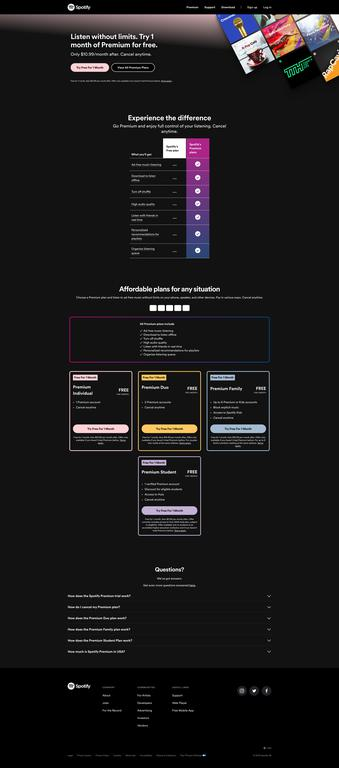

Text Prompt for the Model:

Analyze the provided screenshot of a web application.
Your goal is to reproduce the HTML and CSS code that, when rendered, would create a visually similar page.

**Instructions:**
1.  Generate minimal, well-formatted HTML.
2.  Use inline CSS (within `<style>` tags in the `<head>`, or directly on elements if simpler).
3.  Do NOT include any JavaScript (`<script>` tags).
4.  Focus on visual fidelity with the screenshot.
5.  Structure the HTML logically.
6.  Provide **only** the `<html>...</html>` code block. Do not include any explanations, apologies, or surrounding 
text outside the HTML block.

In [4]:
from PIL import (
    Image as PILImage,
)  # Renamed to avoid conflict with IPython.display.Image
from io import BytesIO


def encode_image_to_base64(
    image_path: Path,
    max_dim: int = 512,
    jpeg_quality: int = 75,  # Adjusted default quality for better balance
) -> Tuple[str, str, Tuple[int, int]]:
    """
    Opens an image, downscales it so its longest side is max_dim,
    saves it as a JPEG with the given quality into memory,
    and returns (base64_string, media_type, (width, height)).
    """
    if not image_path.exists():
        logger.error(f"Screenshot not found: {image_path}")
        raise FileNotFoundError(f"{image_path} does not exist")

    # 1) Open & downscale
    img = PILImage.open(image_path)
    original_size = img.size
    img.thumbnail((max_dim, max_dim), PILImage.LANCZOS)
    processed_size = img.size

    # 2) JPEG-compress into a buffer
    buffer = BytesIO()
    img = img.convert("RGB")  # JPEG requires no alpha
    img.save(buffer, format="JPEG", quality=jpeg_quality, optimize=True)
    buffer.seek(0)

    # 3) Base64 encode
    b64_data = base64.b64encode(buffer.read()).decode("utf-8")
    media_type = "image/jpeg"

    logger.info(
        f"Encoded image {image_path.name}: "
        f"Original {original_size[0]}x{original_size[1]}px, "
        f"Processed {processed_size[0]}x{processed_size[1]}px, "
        f"JPEG Q{jpeg_quality}, Base64 size {len(b64_data)} chars."
    )
    return b64_data, media_type, processed_size


# Usage:
SCREENSHOT_PATH = (
    Path("data") / "spotify.png"
)  # Ensure this path is correct for your environment
# Create a dummy image if it doesn't exist for testing
if not SCREENSHOT_PATH.exists():
    try:
        from PIL import ImageDraw

        SCREENSHOT_PATH.parent.mkdir(parents=True, exist_ok=True)
        img = PILImage.new("RGB", (1024, 768), color="skyblue")
        draw = ImageDraw.Draw(img)
        draw.rectangle([100, 100, 300, 200], fill="lightgreen", outline="black")
        draw.text((110, 110), "Hello World App", fill="black")
        img.save(SCREENSHOT_PATH)
        logger.info(f"Created dummy image at {SCREENSHOT_PATH}")
    except Exception as e:
        logger.error(
            f"Could not create dummy image: {e}. Please provide a real image at {SCREENSHOT_PATH}"
        )
        # Or raise an error if image is critical
        # raise

encoded_image_data, image_media_type, image_dimensions = encode_image_to_base64(
    SCREENSHOT_PATH,
    max_dim=768,  # Increased max_dim for potentially better detail
    jpeg_quality=75,  # Good balance for quality/size
)

# Display the image that will be sent to the model
console.print(
    f"\n[bold blue]Input Image Preview ({SCREENSHOT_PATH.name} downscaled):[/bold blue]"
)
display(IPImage(data=base64.b64decode(encoded_image_data)))


# **Improved Prompting for Multimodal Input:**
# The image is now passed as a separate block in the API request,
# not embedded as a base64 string directly in the text prompt.
TEXT_PROMPT = """Analyze the provided screenshot of a web application.
Your goal is to reproduce the HTML and CSS code that, when rendered, would create a visually similar page.

**Instructions:**
1.  Generate minimal, well-formatted HTML.
2.  Use inline CSS (within `<style>` tags in the `<head>`, or directly on elements if simpler).
3.  Do NOT include any JavaScript (`<script>` tags).
4.  Focus on visual fidelity with the screenshot.
5.  Structure the HTML logically.
6.  Provide **only** the `<html>...</html>` code block. Do not include any explanations, apologies, or surrounding text outside the HTML block.
"""
console.print("\n[bold blue]Text Prompt for the Model:[/bold blue]")
console.print(f"[dim]{TEXT_PROMPT}[/dim]")

# 4. Invocation & Parsing

In [5]:
from datetime import datetime, timezone


def build_payload(
    text_prompt: str,
    cfg: ModelConfig,
    image_data: Optional[str] = None,
    image_media_type: Optional[str] = None,
) -> Dict[str, Any]:
    """
    Builds the payload for Anthropic Claude models on Bedrock,
    supporting multimodal input.
    """
    content_blocks: List[Dict[str, Any]] = []

    if image_data and image_media_type:
        content_blocks.append(
            {
                "type": "image",
                "source": {
                    "type": "base64",
                    "media_type": image_media_type,
                    "data": image_data,
                },
            }
        )

    content_blocks.append(
        {
            "type": "text",
            "text": text_prompt,
        }
    )

    payload = {
        "messages": [{"role": "user", "content": content_blocks}],
        "max_tokens": cfg.max_output_tokens,  # API parameter is 'max_tokens' for output
        "temperature": cfg.temperature,
        "anthropic_version": "bedrock-2023-05-31",  # Use the latest appropriate version
    }
    if cfg.thinking:
        payload["thinking"] = cfg.thinking

    return payload


def parse_bedrock_response(
    body_bytes: bytes,
    text_prompt_for_fallback: str,  # Used only if API doesn't return token counts
    cfg: ModelConfig,
) -> Tuple[str, str, int, int]:
    """
    Parses the Bedrock API response.
    Returns (full_text, reasoning, tokens_in, tokens_out).
    Attempts to use reported usage if present.
    Fallback for token counts is approximate.
    """
    data = json.loads(body_bytes)

    # 1) Try to pull 'usage' fields (primary source of truth for tokens)
    usage = data.get("usage", {})
    tokens_in = (
        usage.get("input_tokens", 0)
        or usage.get("prompt_tokens", 0)
        or usage.get("promptTokens", 0)
        or 0
    )
    tokens_out = (
        usage.get("output_tokens", 0)
        or usage.get("completion_tokens", 0)
        or usage.get("completionTokens", 0)
        or 0
    )

    # 2) Extract text + reasoning (Claude 3+ structure)
    # The 'content' is a list of blocks. Text output is usually in the first text block.
    # 'thinking' can appear as separate blocks or within content blocks.
    full_text = ""
    reasoning_parts = []

    if "content" in data and isinstance(data["content"], list):
        for block in data["content"]:
            if block.get("type") == "text":
                full_text += block.get("text", "")
            if "thinking" in block:  # Thinking can be a top-level key in a block
                reasoning_parts.append(block["thinking"])
    elif "completion" in data:  # Fallback for older/different structures
        full_text = data.get("completion", "")

    # Anthropic 'thinking' results might also be in a top-level 'thinking' field
    # (though less common with messages API if 'thinking' parameter is used right)
    if "thinking" in data and isinstance(data["thinking"], (str, dict)):
        reasoning_parts.append(str(data["thinking"]))

    full_text = full_text.strip()
    reasoning = "\n---\n".join(reasoning_parts).strip()

    # 3) Fallback to whitespace‐split counts if API didn't provide usage.
    #    NOTE: Input token fallback is highly inaccurate for multimodal inputs,
    #    as it only considers the text prompt. API 'usage' is crucial.
    if tokens_in == 0 and text_prompt_for_fallback:
        tokens_in = len(text_prompt_for_fallback.split())
        logger.warning(
            f"Used fallback for input token count for {cfg.display_name} (text only). "
            f"This is inaccurate for multimodal. API did not return 'input_tokens'."
        )
    if tokens_out == 0 and full_text:
        tokens_out = len(full_text.split())
        logger.warning(
            f"Used fallback for output token count for {cfg.display_name}. "
            "API did not return 'output_tokens'."
        )

    # Ensure HTML extraction (model might still add preamble/postamble)
    # This is a basic extraction. More robust parsing might be needed.
    if "<html>" in full_text and "</html>" in full_text:
        start_index = full_text.find("<html>")
        end_index = full_text.rfind("</html>") + len("</html>")
        extracted_html = full_text[start_index:end_index]
        if extracted_html != full_text:
            logger.info("Extracted HTML block from model output.")
            full_text = extracted_html
    elif (
        full_text.strip().startswith("<")
        and full_text.strip().endswith(">")
        and not full_text.strip().startswith("<?xml")
    ):
        # If it looks like a single HTML structure without the <html> tags, wrap it.
        # This can happen if the model *only* returns e.g. a <div> structure.
        # Forcing <html> tags for consistency in rendering.
        # logger.info("Output seems to be an HTML fragment; wrapping with <html><body>...</body></html>")
        # full_text = f"<html>\n<head><style></style></head>\n<body>\n{full_text}\n</body>\n</html>"
        # Decided against auto-wrapping, as the prompt asks for <html>...</html>
        pass

    return full_text, reasoning, tokens_in, tokens_out


def invoke_model(
    cfg: ModelConfig,
    text_prompt: str,
    image_data: Optional[str] = None,
    image_media_type: Optional[str] = None,
) -> Dict[str, Any]:
    logger.info(f"Invoking model: {cfg.display_name}")
    payload = build_payload(text_prompt, cfg, image_data, image_media_type)

    # For debugging the payload:
    # logger.debug(f"Payload for {cfg.display_name}: {json.dumps(payload, indent=2)[:500]}...") # Truncate image data

    start_time = datetime.now(timezone.utc)

    try:
        response = bedrock_client.invoke_model(
            modelId=cfg.model_id,
            contentType="application/json",
            accept="application/json",
            body=json.dumps(payload),  # No need to encode to utf-8 here, SDK handles it
        )
    except Exception as exc:
        logger.error(f"Error invoking {cfg.display_name} (ID: {cfg.model_id}): {exc}")
        return {
            "name": cfg.display_name,
            "model_id_used": cfg.model_id,
            "status": "ERROR",
            "error": str(exc),
            "html": "<!-- Error during model invocation -->",
            "latency_s": (datetime.now(timezone.utc) - start_time).total_seconds(),
            "tokens_in": 0,
            "tokens_out": 0,
            "thinking_tokens": 0,
            "cost_usd": 0.0,
            "reasoning": "",
        }

    latency = (datetime.now(timezone.utc) - start_time).total_seconds()
    body_bytes = response["body"].read()

    try:
        html_output, reasoning_output, tokens_in, tokens_out = parse_bedrock_response(
            body_bytes, text_prompt, cfg
        )
    except json.JSONDecodeError as json_err:
        logger.error(
            f"Failed to parse JSON response from {cfg.display_name}: {json_err}"
        )
        logger.error(
            f"Raw response body: {body_bytes.decode(errors='ignore')[:1000]}"
        )  # Log snippet of raw body
        return {
            "name": cfg.display_name,
            "model_id_used": cfg.model_id,
            "status": "PARSE_ERROR",
            "error": f"JSONDecodeError: {json_err}",
            "html": "<!-- Error parsing model response -->",
            "latency_s": latency,
            "tokens_in": 0,  # Unknown
            "tokens_out": 0,  # Unknown
            "thinking_tokens": 0,
            "cost_usd": 0.0,
            "reasoning": "",
        }

    cost = round(
        tokens_in * cfg.rate_in + tokens_out * cfg.rate_out, 6
    )  # Increased precision for cost

    # Estimate thinking tokens (very approximate)
    # The 'thinking' feature's token consumption might be part of input/output tokens
    # or billed separately depending on the model and feature version.
    # This is just an estimate of the *length* of the reasoning text.
    thinking_tokens_estimate = len(reasoning_output.split()) if reasoning_output else 0

    # Pacing between calls - good practice
    sleep(1)

    return {
        "name": cfg.display_name,
        "model_id_used": cfg.model_id,
        "status": "OK",
        "latency_s": round(latency, 2),
        "tokens_in": tokens_in,
        "tokens_out": tokens_out,
        "thinking_tokens": thinking_tokens_estimate,  # Length of reasoning text
        "cost_usd": cost,
        "html": html_output,
        "reasoning": reasoning_output,
    }

In [6]:
SELECT_MODEL_KEYS: Union[None, str, List[str]] = (
    "sonnet3.7_high"  # Example: "sonnet3.7_high" or ["haiku3.5", "sonnet3.5v2"] or None for all
)

if SELECT_MODEL_KEYS is None or (
    isinstance(SELECT_MODEL_KEYS, str) and SELECT_MODEL_KEYS.upper() == "ALL"
):
    selected_cfgs = EVAL_MODELS
    run_title = "All Models"
elif isinstance(SELECT_MODEL_KEYS, str):
    selected_cfgs = [m for m in EVAL_MODELS if m.key == SELECT_MODEL_KEYS]
    run_title = SELECT_MODEL_KEYS
elif isinstance(SELECT_MODEL_KEYS, list):
    selected_cfgs = [m for m in EVAL_MODELS if m.key in SELECT_MODEL_KEYS]
    run_title = ", ".join(SELECT_MODEL_KEYS)
else:
    raise ValueError(f"Invalid SELECT_MODEL_KEYS value: {SELECT_MODEL_KEYS}")

if not selected_cfgs:
    valid_keys = [m.key for m in EVAL_MODELS]
    raise ValueError(
        f"No model matching key(s)={SELECT_MODEL_KEYS!r}. " f"Valid keys: {valid_keys}"
    )

In [ ]:
console.print(f"[bold green]Starting benchmark for: {run_title}[/bold green]")
results = []
# Using tqdm for progress bar
for cfg in tqdm(selected_cfgs, desc="Benchmarking Models"):
    results.append(invoke_model(cfg, TEXT_PROMPT, encoded_image_data, image_media_type))

# Separate successes and failures
successes = [r for r in results if r["status"] == "OK"]
failures = [r for r in results if r["status"] != "OK"]

if failures:
    console.print(
        "\n[bold yellow]⚠️ Some model invocations failed or had issues:[/bold yellow]"
    )
    for fail_res in failures:
        console.print(
            f" • [bold]{fail_res['name']}[/bold] (ID: {fail_res.get('model_id_used', 'N/A')}): Status '{fail_res['status']}' - {fail_res['error']}"
        )

if successes:
    # Added 'Model ID' to the DataFrame for clarity
    df_data = []
    for r in successes:
        df_data.append(
            {
                "Model Name": r["name"],
                "Model ID Suffix": r["model_id_used"]
                .split(":")[-2]
                .split("/")[-1],  # Show relevant part of ID
                "Latency (s)": r["latency_s"],
                "Tokens In": r["tokens_in"],
                "Tokens Out": r["tokens_out"],
                "Thinking Tokens (est.)": r["thinking_tokens"],
                "Cost (USD)": f"${r['cost_usd']:.4f}",  # Format cost
            }
        )

    df = pd.DataFrame(df_data)

    console.rule(f"📊 Run Metrics — {run_title}")
    # Using rich Table for better console output if preferred, or tabulate
    # rich_table = Table(show_header=True, header_style="bold magenta")
    # for col in df.columns:
    #     rich_table.add_column(col, justify="right" if "Tokens" in col or "Cost" in col or "Latency" in col else "left")
    # for index, row in df.iterrows():
    #     rich_table.add_row(*[str(x) for x in row.values])
    # console.print(rich_table)

    # Using tabulate as in original, but with formatted cost
    print(tabulate(df, headers="keys", tablefmt="pretty", showindex=False))
else:
    if (
        not failures
    ):  # Only print this if there were no failures either (i.e. no models selected/run)
        console.print(
            "[bold red]❌ No models were selected or run successfully.[/bold red]"
        )

Starting benchmark for: sonnet3.7_high

Benchmarking Models:   0%|          | 0/1 [00:00<?, ?it/s]

2025-05-07 15:04:06,732 [INFO] webapp_html_benchmark: Invoking model: Claude 3.7 Sonnet (high reasoning, Lab ID)


# 6. Render Outputs Inline

In [ ]:
if successes:
    console.print(f"\n[bold cyan]🖼️ Generated HTML Outputs & Reasoning:[/bold cyan]")
    for res in successes:
        console.rule(f"🔧 Output — {res['name']}")

        console.print("[bold]Raw HTML Output:[/bold]")
        # Display raw HTML in a scrollable preformatted block
        display(
            HTML(
                f"<pre style='white-space: pre-wrap; border:1px solid #ddd; padding:10px; max-height: 300px; overflow-y: auto;'>"
                f"{res['html']}</pre>"
            )
        )

        # console.print(
        #     "\n[bold]Visual Render (experimental - might break notebook layout):[/bold]"
        # )
        # # Visual render - uncomment with caution if HTML is very large or complex
        # # Using an iframe for better isolation
        # html_to_render = res["html"]
        # if not html_to_render.strip():
        #     html_to_render = (
        #         "<!-- Model returned empty HTML --> <p>Model returned empty HTML.</p>"
        #     )

        # # Sanitize or be careful with arbitrary HTML rendering
        # # Forcing <html> and <body> tags if not present for iframe rendering
        # if not html_to_render.strip().lower().startswith("<html"):
        #     html_to_render = f"<html><head><title>Render</title></head><body>{html_to_render}</body></html>"

        # # Use a data URI for the iframe src to avoid issues with local file paths or complex HTML
        # # Some complex CSS or resources might not render perfectly in an iframe this way.
        # iframe_src = f"data:text/html;charset=utf-8,{base64.b64encode(html_to_render.encode('utf-8')).decode('utf-8')}"
        # display(
        #     HTML(
        #         f"<iframe src='data:text/html;base64,{base64.b64encode(html_to_render.encode('utf-8')).decode('utf-8')}' "
        #         f"width='100%' height='400px' style='border:1px solid #ccc;' sandbox></iframe>"
        #     )
        # )

        if res["reasoning"]:
            console.print("\n[italic]Captured Reasoning (truncated):[/italic]")
            console.print(
                res["reasoning"][:1000] + ("…" if len(res["reasoning"]) > 1000 else "")
            )
        else:
            console.print("\n[italic]No reasoning captured for this model.[/italic]")
else:
    console.print(
        "\n[bold yellow]No successful model outputs to display.[/bold yellow]"
    )

In [ ]:
for res in successes:
    console.rule(f"🔧 Output — {res['name']}")
    # raw HTML
    display(
        HTML(
            f"<pre style='white-space: pre-wrap; border:1px solid #ddd; padding:10px;'>"
            f"{res['html']}</pre>"
        )
    )
    # visual render
    # display(HTML(res["html"]))
    if res["reasoning"]:
        console.print("[italic]Captured reasoning (truncated):[/italic]")
        console.print(
            res["reasoning"][:500] + ("…" if len(res["reasoning"]) > 500 else "")
        )

# 7. Discussion & Next Steps
 Latency vs. Quality:
 - Generally, more capable models (like Sonnet versions here) might have higher latency
   but produce more accurate or complex HTML. Haiku aims for speed.
 - The 'thinking' budget can also impact latency and output quality.

 Cost trade-offs:
 - Faster/cheaper models (Haiku) are good for simpler tasks or drafts.
 - More expensive models (Sonnet) are for higher fidelity requirements.
 - Token usage (input and output) directly impacts cost. Input includes image tokens.

 When to surface full reasoning:
 - For debugging: Understanding why a model made certain choices.
 - For iterative prompting: Refining instructions based on the model's thought process.
 - Not usually for end-users unless it's a specific "show your work" feature.

 Tip: you can easily tweak temperature, max_output_tokens, or swap in other
 Bedrock-hosted models (e.g., from Cohere, AI21, Meta, Amazon Titan)
 by adding another ModelConfig and rerunning the above cells. Remember that
 payload structures and supported parameters can vary between model providers.

 **Further Improvements & Considerations:**
 - **Advanced HTML Parsing:** The current HTML extraction is basic. For production, use robust HTML parsers (e.g., BeautifulSoup) to clean/validate output.
 - **CSS Handling:** Inline CSS is simple but can be verbose. Consider asking the model for CSS in a `<style>` block or even as a separate output for more complex UIs.
 - **Image Preprocessing:** Experiment with `max_dim` and `jpeg_quality` for images. Higher resolution/quality means more input tokens and cost, but potentially better results.
 - **Iterative Refinement:** Consider a multi-step process: first call for layout, then for styling, etc.
 - **Component Recognition:** For complex UIs, one could try to make the model identify common web components (buttons, navbars, cards) and use standard structures.
 - **Quantitative Evaluation:** Visual inspection is good, but for rigorous benchmarking, consider metrics like Pixel-Difference, Structural Similarity (SSIM) between rendered HTML and original screenshot, or HTML structure similarity scores. This is complex to set up.
 - **Alternative Model Providers:** The notebook is structured for Anthropic models. Adapting to other providers (e.g., OpenAI, Google Gemini via Vertex AI or other Bedrock integrations) would require changing `build_payload` and `parse_bedrock_response` according to their specific API requirements.

 Key points from original:
 - We read and base64-encode the screenshot. The new method passes it structurally to the model.
 - `invoke_model` collects everything: latency, in/out tokens, cost, and any reasoning.
 - Rendering returned HTML is done via `display(HTML(...))` and now within an iframe for better isolation.

 Feel free to adapt this scaffold to more advanced “cascades” (e.g. feeding the HTML back into a second model for refinement or JavaScript generation).